# **Part of Speech Tagging using Hidden Markov Models**



In this assignment, you are asked to train your **OWN** Hidden Markov Model to predict part of speech tags of words. Steps to the assignment:
1. Download the data from this link - both the web.conllu and wiki.conllu: https://github.com/google-research-datasets/turkish-treebanks/tree/master/data
1. We combined the web and the wiki to have a bigger dataset. Split this dataset (*sentences*) into train/test sets with 0.8/0.2 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Calculate the transition and emission probabilities using the Maximum Likelihood Estimation (MLE). You can use smoothing for transition and emission probabilities.
1. Train two HMMs with two sets of Part-of-Speech tags.

  a. All of the POS tags in the dataset. There are 14 POS tags in the dataset.

  b. Only the tags "ADJ, ADV, NOUN, VERB, PUNCT"
1. Add the "\<START>" and "\<END>" tags for calculating the induction and ending probabilities.
1. Predict the tags for the test set using Viterbi algorithm with the trained HMM.
1. Evaluate the prediction with the gold labels. Show confusion matrix for the tags.
1. Compare the two versions of the HMMs in terms of accuracy and F1 score - all tags version, only "ADJ, ADV, NOUN, VERB, PUNC" version.
1. Write a small report on your approaches and results.


## Rules
### Allowed:
 - Use any libraries for anything **other than the HMM training and prediction**.
 - Use strategies to increase the performance like handling unknown or rare words, using a dictionary of open/closed words for prediction, changing smoothing functions, and others.
 - Adding additional coding blocks

### Not allowed:
 - **You need to write your own HMM.** Using the HMM model from an external library is not allowed.
 - You should not use others' codes. We will cross check the submissions.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 500 words). Please include all of the following points in the report:
 - Data preparation method
 - How did you calculate of MLE probabilities for transition and emission matrices?
 - Challenges you have faced while writing the HMM model and challenges with the specific dataset
 - Comments about the performance of your HMM tagger
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.25),
 - clear commenting (0.25),
 - data preparation (0.5),
 - HMM transition and emission probability calculation (2)
 - POS tagging the test data with trained HMM using Viterbi algorithm (1.5)
 - Evaluation of the performance of HMM POS tagger (0.5)
 - assignment report (1).

Total points for this assignment = 6


## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_hmm_tagger.ipynb  - ex. 26744_aysegulrana_hmm_tagger.ipynb`


**Deadline is December 8th, 23.55pm.**


In [492]:
# Script for downloading data
import os, urllib.request, pathlib

data_dir = "/content"
base = "https://raw.githubusercontent.com/google-research-datasets/turkish-treebanks/master/data"

pathlib.Path(data_dir).mkdir(parents=True, exist_ok=True)

for name in ("web.conllu", "wiki.conllu"):
    url = f"{base}/{name}"
    dest = f"{data_dir}/{name}"
    if not os.path.exists(dest):
        print(f"Downloading {url} -> {dest}")
        urllib.request.urlretrieve(url, dest)
    else:
        print(f"Found existing {dest}")

web_file_path = f"{data_dir}/web.conllu"
wiki_file_path = f"/{data_dir}/wiki.conllu"

print("web exists =", os.path.exists(f"{data_dir}/web.conllu"))
print("wiki exists =", os.path.exists(f"{data_dir}/wiki.conllu"))


Found existing /content/web.conllu
Found existing /content/wiki.conllu
web exists = True
wiki exists = True


In [493]:
def read_conll(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # Skip metadata lines starting with "#"
            if line.startswith("#"):
                continue

            # Sentence boundary (blank line)
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                # Split the line into columns and extract word and POS tag
                columns = line.split('\t')
                if len(columns) > 3:  # Check to ensure the line has expected columns
                    word = columns[2]
                    if word == '_':
                      continue

                    pos_tag = columns[3]
                    sentence.append((word, pos_tag))

        # Add the last sentence if the file doesn't end with a blank line
        if sentence:
            sentences.append(sentence)

    return sentences

# Usage
web_file_path = "/content/web.conllu"
wiki_file_path = "/content/wiki.conllu"

web_sentences = read_conll(web_file_path)
wiki_sentences = read_conll(wiki_file_path)

sentences = web_sentences + wiki_sentences

In [494]:
len(sentences)

4851

In [495]:
# Check if ANY empty lists in data
print(any(len(s) == 0 for s in sentences))
# print first 3 sentence
for i in range(3):
    print(f"--- Sentence {i+1} ---")
    print(sentences[i])
    print("\n")

False
--- Sentence 1 ---
[('bur', 'PRON'), ('da', 'PRT'), ('öyle', 'VERB'), ('yoksa', 'CONJ'), ('kilo', 'VERB'), ('mı', 'PRT'), ('?', 'PUNCT')]


--- Sentence 2 ---
[('açık', 'NOUN'), ('soru', 'NOUN'), ('müfredat', 'NOUN'), ('uygun', 'ADJ'), ('ol', 'VERB'), ('ol', 'VERB'), ('bil', 'VERB'), ('imkan', 'NOUN'), ('.', 'PUNCT')]


--- Sentence 3 ---
[('bakara', 'NOUN'), ('sure', 'NOUN'), ('248', 'NUM'), ('ayet', 'NOUN'), ('açık', 'NOUN'), ('mı', 'VERB'), ('?', 'PUNCT')]




## 1. Preprocessing function

In [496]:
def prepare_data(sentences, tag_list):

    # If no tag_list is provided return data exactly as is (First model A)
    if tag_list is None:
        return sentences

    # Filter tags (for second model B)
    target_tags = set(tag_list)
    prepared_sentences = []

    for sentence in sentences:
        new_sentence = []
        for word, tag in sentence:
            # ONLY add the word if its tag is in our allowed list
            if tag in target_tags:
                new_sentence.append((word, tag))
        
        # Only add the sentence if it's not empty after filtering
        if len(new_sentence) > 0:
            prepared_sentences.append(new_sentence)

    return prepared_sentences

## 2. Train test split

In [497]:
### WRITE YOUR CODE HERE ###
from sklearn.model_selection import train_test_split

# Random Split (80% Train, 20% Test)
train_data_raw, test_data_raw = train_test_split(sentences, test_size=0.2, random_state=1234)

print(f"Training Set: {len(train_data_raw)}")
print(f"Test Set: {len(test_data_raw)}")

# 1. Prepare Data for Model A (All Tags)
train_data_A = prepare_data(train_data_raw, None)
test_data_A = prepare_data(test_data_raw, None)

# 2. Prepare Data for Model B (Restricted Tags only tokens with these tags are kept others are removed)
target_tags = ["ADJ", "ADV", "NOUN", "VERB", "PUNCT"]
train_data_B = prepare_data(train_data_raw, target_tags)
test_data_B = prepare_data(test_data_raw, target_tags)

# Display samples
print("\n--- Model A Sample (All Tags) ---")
print(train_data_A[0][:5]) # First 5 tokens of first sentence

print("\n--- Model B Sample (Restricted Tags) ---")
print(train_data_B[0][:5]) # Same sentence

Training Set: 3880
Test Set: 971

--- Model A Sample (All Tags) ---
[('uzun', 'ADJ'), ('zaman', 'NOUN'), ('şeker', 'NOUN'), ('bir', 'DET'), ('kek', 'NOUN')]

--- Model B Sample (Restricted Tags) ---
[('uzun', 'ADJ'), ('zaman', 'NOUN'), ('şeker', 'NOUN'), ('kek', 'NOUN'), ('tarif', 'NOUN')]


## 3. Model Training

Train your HMM here.

In [498]:
def create_HMM(train_sentences):
    '''
    type train_sentences: list of tuples
    param train_sentences: The list of tuples  (word, POS tag) for the training data sentences
    rtype: dict
    return: the transitions count dictionary between tags
    rtype: dict
    return: the emissions count dictionary for tags and words
    rtype: dict
    return: the tag count dictionary for the POS tags
    rtype: set
    return: the vocabulary of the corpus
    '''

    ### WRITE YOUR CODE HERE ###
    # Initialize dictionaries
    transitions = {}  
    emissions = {}   
    tags = {}         
    word_count = {}  
    vocab = set()

    # Iterate each sentence
    for sentence in train_sentences:
        prev_tag = "<START>"
        
        # Initialize <START> in tags dictionary 
        if prev_tag not in tags:
            tags[prev_tag] = 0
        tags[prev_tag] += 1
        
        for word, tag in sentence:
            # Handle Transitions (prev_tag -> tag)
            # If the previous tag row don't exist create it
            if prev_tag not in transitions:
                transitions[prev_tag] = {}
            
            # If the specific transition (prev -> curr) doesn't exist start at 0
            if tag not in transitions[prev_tag]:
                transitions[prev_tag][tag] = 0
                
            transitions[prev_tag][tag] += 1
            
            # --- Handle Emissions (tag -> word) ---
            # If the tag row don't exist in emissions, create it
            if tag not in emissions:
                emissions[tag] = {}
                
            # If the word entry doesn't exist for this tag, start at 0
            if word not in emissions[tag]:
                emissions[tag][word] = 0
                
            emissions[tag][word] += 1
            
            # Tag Counts
            if tag not in tags:
                tags[tag] = 0
            tags[tag] += 1
            
            # Vocab and Word Counts
            vocab.add(word)
            
            if word not in word_count:
                word_count[word] = 0
            word_count[word] += 1
            
            # Update prev_tag 
            prev_tag = tag
            
        # Handle End of Sentence (last_tag -> <END>)
        if prev_tag not in transitions:
            transitions[prev_tag] = {}
            
        if "<END>" not in transitions[prev_tag]:
            transitions[prev_tag]["<END>"] = 0
        
            
        transitions[prev_tag]["<END>"] += 1

        
        # Add <END> to tag_counts with count 0
        
        if "<END>" not in tags:
            tags["<END>"] = 0

    return transitions, emissions, tags, vocab, word_count

In [499]:
#transitions, emissions, tag_counts, vocab, word_count = create_HMM(train_sentences)

# 1. Create Counts for first model (All Tags)
print("Counting Model A...")
trans_A, emit_A, tags_A, vocab_A, wc_A = create_HMM(train_data_A)

# 2. Create Counts for second model (Restricted Tags)
print("Counting Model B...")
trans_B, emit_B, tags_B, vocab_B, wc_B = create_HMM(train_data_B)

print("Counts created successfully!")

Counting Model A...
Counting Model B...
Counts created successfully!



### Calculate Probabilities and smoothing


In [500]:
from collections import defaultdict
import numpy as np

def calculate_probabilities(transitions, emissions, tag_counts, vocab, word_count, alpha=0.04):

    transition_probs = {}
    emission_probs = {}
    
# --------------------------------------------------
    # Here count how many tags see rare words (cnt=1)
    # I use this later to adjust smoothing for each tag
    # so that tags with more rare words get a bit more alpha, 
    # also I did hyperparameter tuning to get the best alpha but 
    # its not included in the code for more simplicity
# --------------------------------------------------

    rare_word_count = defaultdict(int)

    for word, cnt in word_count.items():
        if cnt == 1:  # word appears only once in training
            for tag in emissions:
                if word in emissions[tag]:
                    rare_word_count[tag] += 1

    total_rare = sum(rare_word_count.values()) + 1e-9

    # weight for each tag based on how many rare words it saw
    rare_weight = {
        tag: rare_word_count[tag] / total_rare
        for tag in emissions
    }

    vocab_size = len(vocab)

   # --------------------------------------------------
 # TRANSITION probabilities, normal Laplace smoothing with α
 # --------------------------------------------------
    all_tags = list(tag_counts.keys())

    for prev_tag in all_tags:
        transition_probs[prev_tag] = {}

        # smoothing denominator
        denominator = tag_counts[prev_tag] + alpha * (len(all_tags) + 1)

        for curr_tag in all_tags + ["<END>"]:
            c = transitions.get(prev_tag, {}).get(curr_tag, 0)
            prob = (c + alpha) / denominator
            transition_probs[prev_tag][curr_tag] = np.log(prob)


    # --------------------------------------------------
    # EMISSION probabilities
    # same Laplace idea but alpha is scaled per-tag
    # based on rare-weight above
    # --------------------------------------------------
    for tag in emissions:
        emission_probs[tag] = {}

        # scale α depending on tag's rare-word strength
        alpha_tag = alpha * rare_weight[tag]

        # avoid α=0  log(0)
        if alpha_tag == 0:
            alpha_tag = alpha * 0.01

        denominator = tag_counts[tag] + alpha_tag * (vocab_size + 1)

        # regular words
        for word in vocab:
            c = emissions[tag].get(word, 0)
            prob = (c + alpha_tag) / denominator
            emission_probs[tag][word] = np.log(prob)

        # unknown words
        unk_prob = alpha_tag / denominator
        emission_probs[tag]["<UNK>"] = np.log(unk_prob)

    return transition_probs, emission_probs


## 4. POS tag prediction for test data

Write Viterbi algorithm to predict the POS tags of the test data.

#### Dict for lemmas/words with unique tags for all sentences they appear in

In [501]:
## CREATE DICT OF MORPHEMES WITH A SINGLE TAG we will use this in viterbi algorithm ##
from collections import defaultdict
  
def build_unambiguous_dict(train_data_raw):

    # (we dont exclude anything in this case because it didn't make much diffrence)
    exclude_tags = {}  # Tags to exclude from unambiguous dict

    lemma_tags = defaultdict(set)

    # Create dict from training data
    # train_data_raw contains (lemma, tag)
    for sent in train_data_raw:
        for lemma, tag in sent:
            l = lemma.lower()     # normalize lemma
            lemma_tags[l].add(tag)

    # create dict
    unambiguous = defaultdict(set)

    for lemma, tagset in lemma_tags.items(): # All morphemes with a single tag are added to the dict
        if len(tagset) == 1:
            only_tag = next(iter(tagset))
            if only_tag not in exclude_tags:     # exclude NUM and PUNCT
                unambiguous[only_tag].add(lemma.lower())

    return unambiguous


unambiguous = build_unambiguous_dict(train_data_raw)
total_unambiguous_words = sum(len(words) for words in unambiguous.values())

print(f"\nTotal POS tags with unambiguous words: {len(unambiguous)}")
print(f"Total unambiguous words: {total_unambiguous_words}")

print("\n" + "-" * 80)
print("Breakdown by POS tag:")
print("-" * 80)

# Sort by count (descending)
sorted_tags = sorted(unambiguous.items(), key=lambda x: len(x[1]), reverse=True)

for tag, words in sorted_tags:
    print(f"{tag:10s}: {len(words):5d} words")



Total POS tags with unambiguous words: 14
Total unambiguous words: 7241

--------------------------------------------------------------------------------
Breakdown by POS tag:
--------------------------------------------------------------------------------
NOUN      :  5895 words
VERB      :   479 words
ADJ       :   309 words
NUM       :   278 words
ADV       :    82 words
X         :    71 words
CONJ      :    43 words
PRON      :    28 words
ADP       :    28 words
DET       :     9 words
PUNCT     :     6 words
PRT       :     6 words
ONOM      :     5 words
AFFIX     :     2 words


#### Viterbi algorithm

In [502]:
import numpy as np
def viterbi(test_sentence, transitions, emissions, tag_counts, word_count, unambiguous):
    '''
    type test_sentence: list of strings
    param test_sentence: list of words in a sentence
    type transitions: dict
    param: the transitions count dictionary between tags
    type emissions: dict
    param: the emissions count dictionary for tags and words
    type tag_counts: dict
    param: the tag count dictionary for the POS tags
    type word_count: int
    param: the word count of the training corpus
    rtype: list
    return: the list of predicted tags for the test sentence

    '''
    # viterbi matrix for the test sentence. The matrix has +2 in each side since we add
    # START and END tags for probability calculation.
    # Note: We use test_sentence here as corrected
    v_matrix = np.empty(shape=(len(tag_counts)+2, len(test_sentence)+2))
    v_matrix.fill(-1)
    v_matrix[0][0] = 0

    # fill up the viterbi matrix for each cell, starting with the first word.
    # for every word, check each tag's probability of appearing here.
    ## iterate over the tags:
    ## calculate the best transition probability for the current tag from a previous tag (again iteration of all possible tags)
    ## calculate the emission probability of word coming up from the current tag
    ## sum them up to get to the best probability of P(tag|word).
    ## keep the best path coming to that cell
    # after filling up the viterbi matrix, follow the best path back to predict the tags from the final cell.
    # in the end you are looking at len(tags)xlen(tags) possibilities for each word

    ### WRITE YOUR CODE HERE ###

    # Correction for Log-Probabilities
    min_prob = -1e20 
    v_matrix.fill(min_prob) #  -1 is a high probability we overwrite this with negative infinity to avoid logic errors.  
    v_matrix[0][0] = 0 

    # Setup State Mapping
    real_tags = sorted([t for t in tag_counts.keys() if t not in ["<START>", "<END>"]])
    states = ["<START>"] + real_tags + ["<END>"]
    tag_to_idx = {tag: i for i, tag in enumerate(states)}

    # Initialize backpointer matrix with same shape as v_matrix
    backpointer = np.zeros(v_matrix.shape, dtype=int)

    # Helper for Emission Probabilities (Handling <UNK> and Unambiguous words)
    def get_emit(tag, word, emissions, unambiguous):
        """
        Emission log-probability with softened unambiguous override.
        """
        w = word.lower()

        # if lemma is unambiguous for this tag we boost it
        if w in unambiguous.get(tag, set()):
            return 0.0   # log(1)

        # lemma unambiguous BUT under DIFFERENT tag we penalize 
        for correct_tag, lemma_set in unambiguous.items():
            if w in lemma_set and correct_tag != tag:
                return -10  # instead of -inf we use a high penalty (probability close to 0)

        # 3) normal emission
        if w in emissions[tag]:
            return emissions[tag][w]
        else:
            return emissions[tag]["<UNK>"]
        

    # Forward Step (Fill the Matrix)
    for t, word in enumerate(test_sentence, start=1):

        # Iterate through Current States (skip START (0) and END (last) for middle columns)
        for curr_tag in real_tags:
            curr_idx = tag_to_idx[curr_tag]
            
            emit_p = get_emit(curr_tag, word, emissions, unambiguous)

            max_prob = min_prob
            best_prev = 0

            # Iterate through Previous States
            possible_prev_states = ["<START>"] if t == 1 else real_tags

            for prev_tag in possible_prev_states:
                prev_idx = tag_to_idx[prev_tag]

                # Transition: Prev -> Curr
                trans_p = transitions[prev_tag].get(curr_tag, min_prob)

                # Viterbi Path Score: Prev_Cell + Transition
                score = v_matrix[prev_idx, t-1] + trans_p

                if score > max_prob:
                    max_prob = score
                    best_prev = prev_idx

            # Set values
            v_matrix[curr_idx, t] = max_prob + emit_p
            backpointer[curr_idx, t] = best_prev

    # Termination Step (Transition to <END>)
    end_col = len(test_sentence) + 1
    end_idx = tag_to_idx["<END>"]

    max_final_prob = min_prob
    best_last_tag_idx = 0

    # Check transitions from all real tags to <END>
    for prev_tag in real_tags:
        prev_idx = tag_to_idx[prev_tag]

        trans_p = transitions[prev_tag].get("<END>", min_prob)

        score = v_matrix[prev_idx, end_col - 1] + trans_p

        if score > max_final_prob:
            max_final_prob = score
            best_last_tag_idx = prev_idx

    v_matrix[end_idx, end_col] = max_final_prob
    backpointer[end_idx, end_col] = best_last_tag_idx

    # Backtracking Step
    predicted_tags = []

    curr_idx = backpointer[end_idx, end_col]

    for t in range(len(test_sentence), 0, -1):
        predicted_tags.append(states[curr_idx])
        curr_idx = backpointer[curr_idx, t]

    predicted_tags = predicted_tags[::-1]

    return predicted_tags


## 5. Evaluate your HMM

Use the test data labels and compare to your prediction. Use the accuracy and F1 score as the performance metrics. Show the confusion matrix for the prediction vs gold labels.


--- Starting Evaluation for Model A (All Tags) ---
Model A Prediction finished in 2.12 seconds.
Model A Accuracy: 0.9141
Model A F1 Score: 0.9129


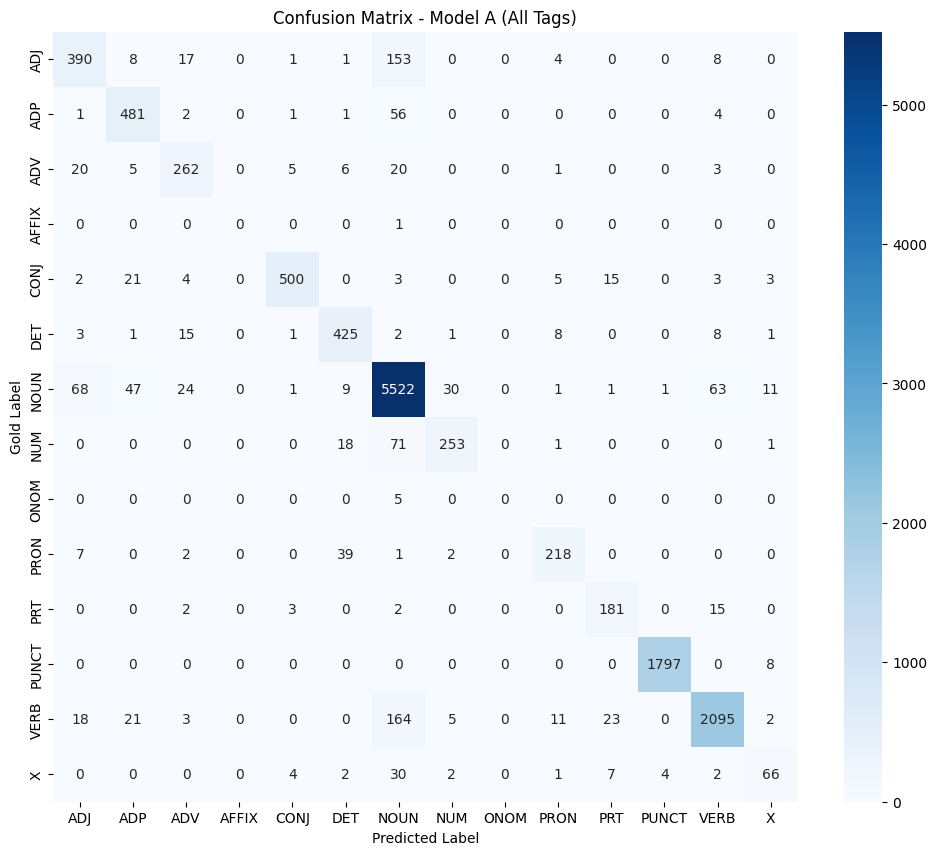


--- Starting Evaluation for Model B (Restricted Tags) ---
Model B Prediction finished in 0.29 seconds.
Model B Accuracy: 0.9437
Model B F1 Score: 0.9428


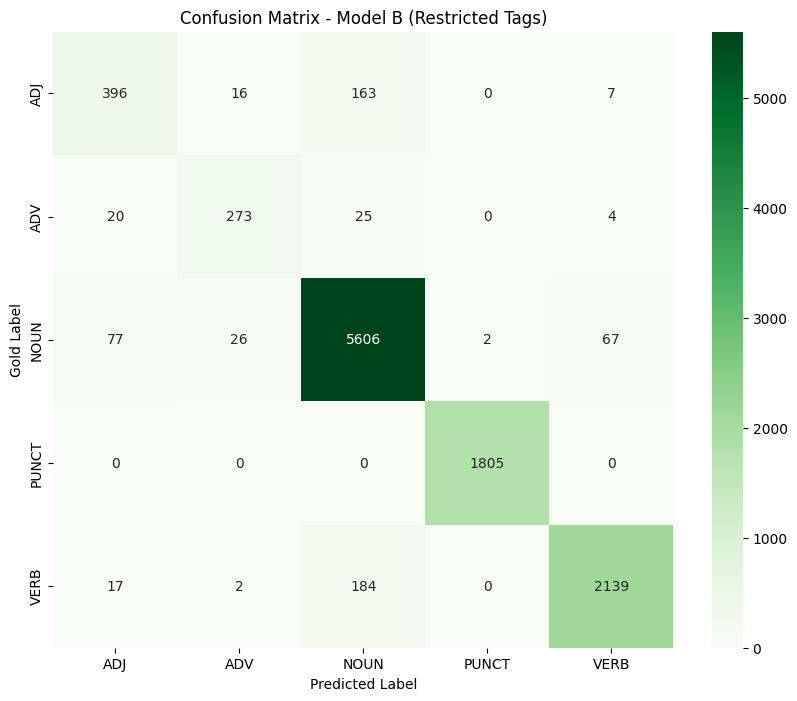


=== Final Report ===
Model A (All Tags)--------> Accuracy: 0.9141, F1: 0.9129
Model B (Restricted Tags)-> Accuracy: 0.9437, F1: 0.9428


In [503]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

### WRITE YOUR CODE HERE ###

# Build Unambiguous Dict for Viterbi
unambiguous = build_unambiguous_dict(train_data_raw)

### EVALUATE MODEL A (ALL TAGS) ###

print("--- Starting Evaluation for Model A (All Tags) ---")

# Calculate Log-Probability Matrices for Model A
trans_probs_A, emit_probs_A = calculate_probabilities(trans_A, emit_A, tags_A, vocab_A, wc_A)

# Prepare Test Data
test_words_A = [[w for w, t in sent] for sent in test_data_A]
gold_tags_A = [[t for w, t in sent] for sent in test_data_A]

# Run Viterbi Prediction
predicted_tags_A = []
start_time = time.time()

for i, sentence in enumerate(test_words_A):
    # Predict using Model A matrices
    preds = viterbi(sentence, trans_probs_A, emit_probs_A, tags_A, vocab_A , unambiguous)
    predicted_tags_A.append(preds)

print(f"Model A Prediction finished in {time.time() - start_time:.2f} seconds.")

# Flatten lists for metrics
flat_gold_A = [tag for sent in gold_tags_A for tag in sent]
flat_pred_A = [tag for sent in predicted_tags_A for tag in sent]

# Calculate Metrics
acc_A = accuracy_score(flat_gold_A, flat_pred_A)
f1_A = f1_score(flat_gold_A, flat_pred_A, average='weighted')

print(f"Model A Accuracy: {acc_A:.4f}")
print(f"Model A F1 Score: {f1_A:.4f}")

# Plot Confusion Matrix
unique_labels_A = sorted(list(set(flat_gold_A)))
cm_A = confusion_matrix(flat_gold_A, flat_pred_A, labels=unique_labels_A)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_A, annot=True, fmt='d', xticklabels=unique_labels_A, yticklabels=unique_labels_A, cmap="Blues")
plt.title("Confusion Matrix - Model A (All Tags)")
plt.ylabel('Gold Label')
plt.xlabel('Predicted Label')
plt.show()


# EVALUATE MODEL B (RESTRICTED TAGS)

print("\n--- Starting Evaluation for Model B (Restricted Tags) ---")

# Calculate Log Probability Matrices for Model B
trans_probs_B, emit_probs_B = calculate_probabilities(trans_B, emit_B, tags_B, vocab_B, wc_B)

# Prepare Test Data
test_words_B = [[w for w, t in sent] for sent in test_data_B]
gold_tags_B = [[t for w, t in sent] for sent in test_data_B]

# Run viterbi
predicted_tags_B = []
start_time = time.time()

for i, sentence in enumerate(test_words_B):
    # Predict using Model B matrices
    preds = viterbi(sentence, trans_probs_B, emit_probs_B, tags_B, vocab_B , unambiguous)
    predicted_tags_B.append(preds)

print(f"Model B Prediction finished in {time.time() - start_time:.2f} seconds.")

# Flatten lists
flat_gold_B = [tag for sent in gold_tags_B for tag in sent]
flat_pred_B = [tag for sent in predicted_tags_B for tag in sent]

# Calculate Metrics
acc_B = accuracy_score(flat_gold_B, flat_pred_B)
f1_B = f1_score(flat_gold_B, flat_pred_B, average='weighted')

print(f"Model B Accuracy: {acc_B:.4f}")
print(f"Model B F1 Score: {f1_B:.4f}")

# Plot Confusion Matrix
unique_labels_B = sorted(list(set(flat_gold_B)))
cm_B = confusion_matrix(flat_gold_B, flat_pred_B, labels=unique_labels_B)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_B, annot=True, fmt='d', xticklabels=unique_labels_B, yticklabels=unique_labels_B, cmap="Greens")
plt.title("Confusion Matrix - Model B (Restricted Tags)")
plt.ylabel('Gold Label')
plt.xlabel('Predicted Label')
plt.show()


# FINAL COMPARISON
print("\n=== Final Report ===")
print(f"Model A (All Tags)--------> Accuracy: {acc_A:.4f}, F1: {f1_A:.4f}")
print(f"Model B (Restricted Tags)-> Accuracy: {acc_B:.4f}, F1: {f1_B:.4f}")

## 6. Explanation

Write your report here.

In the data preparation stage, I used the lemma column provided by the homework in the skeleton code (collumns[2]) and extracted each token as a (lemma, POS) pair in the sentence. For some morphemes where the lemma field was missing we simply skip those rows which were provided in the code. In the function I prepared the dataset in two formats one using all POS tags from the dataset, and another using only the restricted tagsets. By this we train two separate HMM models. Both the training and test sets were then structured as lists of sentences, where each sentence is a sequence of (lemma, tag) tuples. 


For transitions I counted how many times each tag was followed by another tag in the training data and normalized by the total count of the previous tag. For emissions, I counted how often each lemma appeared under each tag and divided by the tag’s total frequency. I also applied Laplace smoothing to avoid zero probabilities for unseen transitions or unseen words. Additionally, I used a rare-word–aware smoothing strategy, tags that observed more rare words received a slightly higher smoothing weight, improving generalization on unseen words.


Handling unknown words was one of the biggest challenges especially because the Turkish dataset is highly morphologically rich and many lemmas appear only once. Choosing an effective smoothing technique, tuning the alpha value, and deciding how to build the unambiguous word dictionary took a significant amount of time. Another difficulty was ensuring that the Viterbi algorithm was implemented efficiently and correctly, especially with log probabilities and START/END states. 


The final HMM tagger performed significantly better than the inital baseline. After adding Laplace smoothing value with rare-word-aware scaling, and adding the unambiguous-lemma dictionary, the accuracy and F1 scores improved consistently. The final restricted-tag model reached around 94-95% accuracy and f1 score. All tags reached 91-92% acuraccy and f1 score. The improvements showed that even simple dictionary overrides and clever smoothing can drastically improve a classical HMM tagger.

If we come to limitations of my approach, we are using hmm's which assumes independence between observations. Which is not correct for a morphologicaly rich language like Turkish. Also my dictonary approach using the training data may not have worked if the training data was small or unbalanced, it might make incorrect assumptions for POS tags of some lemmas. And another limitations is because of using hmm's it doesnt have any contextual understanding, when a word is never seen before in the training data its labeled as UNK, we have limited approaches to solve this. But if we used a state of the art model like BERT, we could handle unseen data better.

To further improve this task, other smoothing techniques could be explored, or incorporate suffix-based features for Turkish morphology. Beyond HMMs, the tagger could be upgraded by using pretrained word or subword embeddings and feeding them into a neural sequence model such as a BiLSTM-CRF which would allow the system to better exploit context and generalize to unseen data.

